In [1]:
# In[0]

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch 
import torch.nn as nn
import os
from PIL import Image, ImageDraw
import numpy as np
from matplotlib.patches import Polygon
import torch.optim as optim
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import random 
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix
from torchsummary import summary
import seaborn as sns
import time

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 

train_path = base_dir + 'semantic-segmentation/train2/' 
valid_path = base_dir + 'semantic-segmentation/valid2/'
test_path = base_dir + 'semantic-segmentation/test2/'

image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.7),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=(-30, 30)),  # Randomly rotate the image by an angle within the range [-15, 15] degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])


class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets, smooth=1e-6):
        # Compute intersection
        intersection = torch.sum(logits * targets)
        
        # Compute Dice coefficient
        dice_coefficient = (2. * intersection + smooth) / (
            torch.sum(logits) + torch.sum(targets) + smooth
        )
        
        # Compute Dice loss
        dice_loss = 1.0 - dice_coefficient
        
        return dice_loss

class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

        # Print lengths of image_files and mask_files for debugging
        print(f"Length of image files: {len(self.image_files)}")
        print(f"Length of mask files: {len(self.mask_files)}")

     # Check consistency of image and mask files
        if len(self.image_files) != len(self.mask_files):
            mismatched_file_index = len(self.image_files) if len(self.image_files) < len(self.mask_files) else len(self.mask_files)
            print(f"Mismatched files: {self.image_files[mismatched_file_index]}")
            raise ValueError("Number of images and masks do not match.")
    
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image_gray = Image.open(img_path).convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray, mask



train_dataset = BrainDataset(train_path, transform=image_transform)
valid_dataset = BrainDataset(valid_path, transform=image_transform)
test_dataset = BrainDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Define cnn encoder-decoder model w/skip connections
class DCNN_EncoderDecoder(nn.Module):
    def __init__(self, in_chans=1, out_chans=32, sampling_factor=2):
        super(DCNN_EncoderDecoder, self).__init__()
        
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1)
        self.enc_relu1 = nn.ReLU(inplace=True)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=sampling_factor)  # Halves dimension
        
        self.enc_conv2 = nn.Conv2d(out_chans, out_chans * 2, kernel_size=3, padding=1)
        self.enc_relu2 = nn.ReLU(inplace=True)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=sampling_factor)  # Halves dimension
        
        self.enc_conv3 = nn.Conv2d(out_chans * 2, out_chans * 4, kernel_size=3, padding=1)
        self.enc_relu3 = nn.ReLU(inplace=True)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=sampling_factor)  # Halves dimension, final small latent space
        
        # Decoder layers
        self.dec_upconv1 = nn.ConvTranspose2d(out_chans * 4, out_chans * 2, kernel_size=2, stride=2)
        self.dec_relu1 = nn.ReLU(inplace=True)
        
        self.dec_upconv2 = nn.ConvTranspose2d(out_chans * 2, out_chans, kernel_size=2, stride=2)
        self.dec_relu2 = nn.ReLU(inplace=True)
        
        self.dec_upconv3 = nn.ConvTranspose2d(out_chans, in_chans, kernel_size=2, stride=2)
        # self.dec_sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.enc_relu1(self.enc_conv1(x))
        x1p = self.enc_pool1(x1)
        
        x2 = self.enc_relu2(self.enc_conv2(x1p))
        x2p = self.enc_pool2(x2)
        
        x3 = self.enc_relu3(self.enc_conv3(x2p))
        x3p = self.enc_pool3(x3)
        
        # Decoder
        x3d = self.dec_relu1(self.dec_upconv1(x3p))
        
        x2d = self.dec_relu2(self.dec_upconv2(x3d))
        
        # x1d = self.dec_sigmoid(self.dec_upconv3(x2d))  # If using BCEWithLogitsLoss.. not needed
        x1d = self.dec_upconv3(x2d)
        return x1d


    




Length of image files: 1501
Length of mask files: 1501
Length of image files: 429
Length of mask files: 429
Length of image files: 215
Length of mask files: 215


In [2]:


def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    # Define loss function
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to device
    model.to(device)
    summary(model, (1, 256, 256))
    
    
    train_loss_history = []
    valid_loss_history = []
    # train_precision_history = []
    valid_precision_history = []
    # train_recall_history = []
    valid_recall_history = []
    # train_f1_history = []
    valid_f1_history = []

    start_time = time.time()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train =0
        # train_TP = 0
        # train_FP = 0
        # train_FN = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad() # zero out the gradients
            outputs = model(images)
            #print(outputs.shape)
            loss = criterion(outputs, masks)

            loss.backward() # back propagate the loss
            optimizer.step()    # update the weights
            train_loss += loss.item() # add the loss to the train loss

            predicted = outputs > 0.5   # threshold the outputs to get the predicted masks
            correct_train += (predicted == masks).sum().item()
            total_train += masks.numel()

            # train_TP += ((predicted == 1) & (masks == 1)).sum().item()
            # train_FP += ((predicted == 1) & (masks == 0)).sum().item()
            # train_FN += ((predicted == 0) & (masks == 1)).sum().item()
            
        train_accuracy = correct_train / total_train
        # train_precision = train_TP / (train_TP + train_FP)
        # train_recall = train_TP / (train_TP + train_FN)
        # train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)

        train_accuracy = correct_train / total_train

        # Validation loop
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        valid_TP = 0
        valid_FP = 0
        valid_FN = 0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                predicted = outputs > 0.5
                correct_valid += (predicted == masks).sum().item()
                total_valid += masks.numel()

                valid_TP += ((predicted == 1) & (masks == 1)).sum().item()
                valid_FP += ((predicted == 1) & (masks == 0)).sum().item()
                valid_FN += ((predicted == 0) & (masks == 1)).sum().item()
        
        valid_accuracy = correct_valid / total_valid

        # Calculate precision, recall, and F1 score
        if valid_TP + valid_FP > 0:
            valid_precision = valid_TP / (valid_TP + valid_FP)
        else:
            valid_precision = 0.0

        if valid_TP + valid_FN > 0:
            valid_recall = valid_TP / (valid_TP + valid_FN)
        else:
            valid_recall = 0.0

        if valid_precision + valid_recall > 0:
            valid_f1 = 2 * (valid_precision * valid_recall) / (valid_precision + valid_recall)
        else:
            valid_f1 = 0.0

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train loss: {train_loss/len(train_loader):.4f}, "
               f"Train accuracy: {train_accuracy:.4f}, "
               f"Validation loss: {valid_loss/len(valid_loader):.4f}, "
               f"Validation accuracy: {valid_accuracy:.4f}")
        
        # Save the loss values for plotting
        train_loss_history.append(train_loss/len(train_loader))
        valid_loss_history.append(valid_loss/len(valid_loader))
        
    end_time = time.time()
    print(f"Validation precision: {valid_precision:.4f}, "
               f"Validation recall: {valid_recall:.4f}, "
               f"Validation F1 score: {valid_f1:.4f}")
    
    print(f"Time taken: {end_time - start_time:.2f}s")
    return model, train_loss_history, valid_loss_history

model = DCNN_EncoderDecoder()
model, train_loss_history, valid_loss_history = train(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.001)





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
  ConvTranspose2d-10           [-1, 64, 64, 64]          32,832
             ReLU-11           [-1, 64, 64, 64]               0
  ConvTranspose2d-12         [-1, 32, 128, 128]           8,224
             ReLU-13         [-1, 32, 128, 128]               0
  ConvTranspose2d-14          [-1, 1, 2

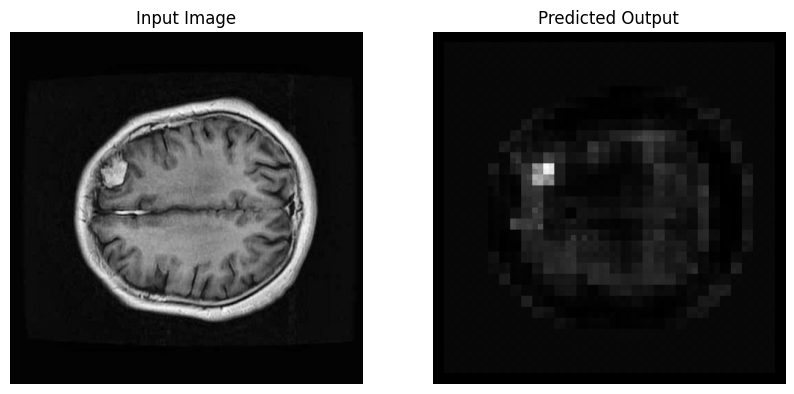

In [13]:
# Save the trained model
base_dir = '/home/csalitre/school/ecgr-5106/final-project/'
torch.save(model.state_dict(), os.path.join(base_dir, 'skipconnection_model.pth'))

# Load the trained model
model_path = os.path.join(base_dir, 'skipconnection_model.pth')
model = DCNN_EncoderDecoder()
model.load_state_dict(torch.load(model_path))
model.eval()

# Load and preprocess the image
image_path = os.path.join(base_dir, "semantic-segmentation/test2/images/27_jpg.rf.b2a2b9811786cc32a23c46c560f04d07.jpg")
image = Image.open(image_path).convert("L")
input_image = image_transform(image).unsqueeze(0)  # Add batch dimension

# Run inference
with torch.no_grad():
    output = model(input_image)

# Convert output tensor to numpy array
output_np = output.squeeze(0).cpu().numpy()


import matplotlib.pyplot as plt
# Plot the input image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# Plot the segmentation
plt.subplot(1, 2, 2)
plt.imshow(output_np[0], cmap='gray')
plt.title('Predicted Output')
plt.axis('off')

plt.show()

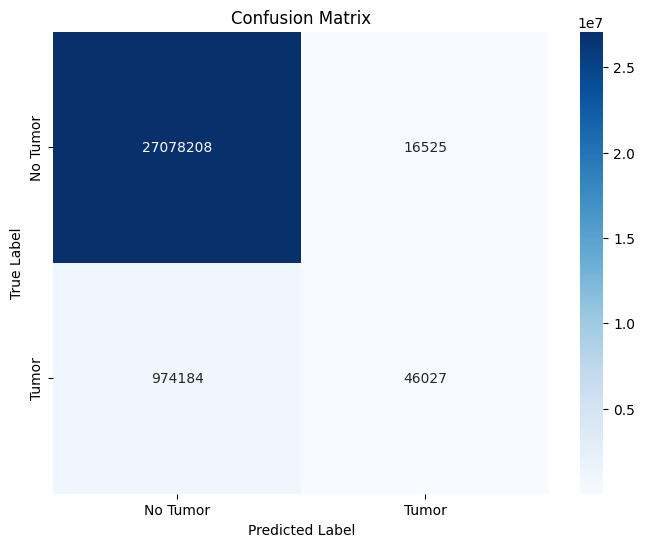

In [12]:
def plot_confusion_matrix(conf_matrix, classes):
    """
    This function plots a given confusion matrix.
    
    Parameters:
    - conf_matrix: numpy array, the confusion matrix to be plotted
    - classes: list of class names for the axis labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def incremental_conf_matrix(model, loader, device, classes):
    model.to(device)
    model.eval()
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Ensure binary predictions by thresholding and converting to integer
            predicted = (outputs > 0.5).float()
            preds = predicted.view(-1).cpu().numpy().astype(int)  # Ensure binary and convert to int
            actuals = masks.view(-1).cpu().numpy().astype(int)    # Ensure masks are also int

            # Incrementally update confusion matrix
            conf_matrix += confusion_matrix(actuals, preds, labels=range(len(classes)))
    return conf_matrix


model.to(device)

conf_matrix = incremental_conf_matrix(model, valid_loader, device, classes=[0, 1])
plot_confusion_matrix(conf_matrix, classes=['No Tumor', 'Tumor'])




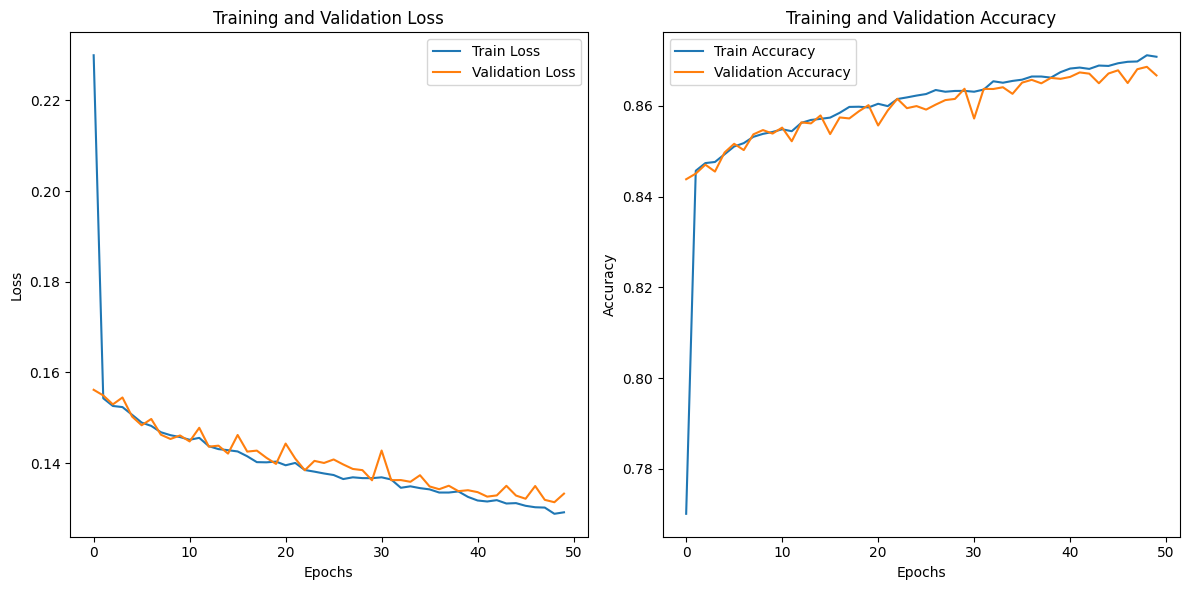

In [20]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Load training and validation accuracy if calculated
# Assuming train_accuracy_history and valid_accuracy_history are returned and saved from your training function
# If they are not calculated and saved, you would need to implement that similarly to how loss is tracked
train_accuracy_history = [1 - loss for loss in train_loss_history]  # Example calculation, replace with actual if available
valid_accuracy_history = [1 - loss for loss in valid_loss_history]  # Example calculation, replace with actual if available

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(valid_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()